This EDA focuses on exploring the data in the CPH census', in order to test the data against HLT

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import plotly.graph_objs as go
import json
from typing import List

from helper_functions import clean_data_age_gender, split_csv

#Future proofing of the way we use pandas
pd.options.mode.copy_on_write = True

# Get in the data
census_data_dir = Path.cwd().parent / 'data' / 'census'

# we load in the first of the census to explore that data
first_census_df = pd.read_csv(census_data_dir / "cph" / 'Rigsarkivet_folketælling_Kobenhavn_amt_1787.csv', delimiter='$')

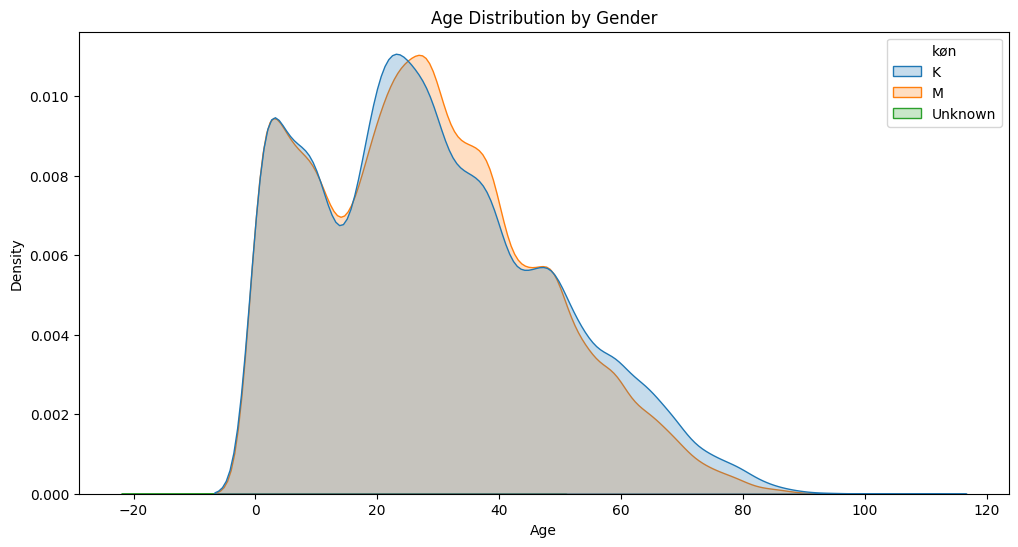

C:\Users\mlind\AppData\Local\Temp\ipykernel_18204\3756818024.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=cleaned_census_df, x='age_full_years', hue='marital_status', shade=True)


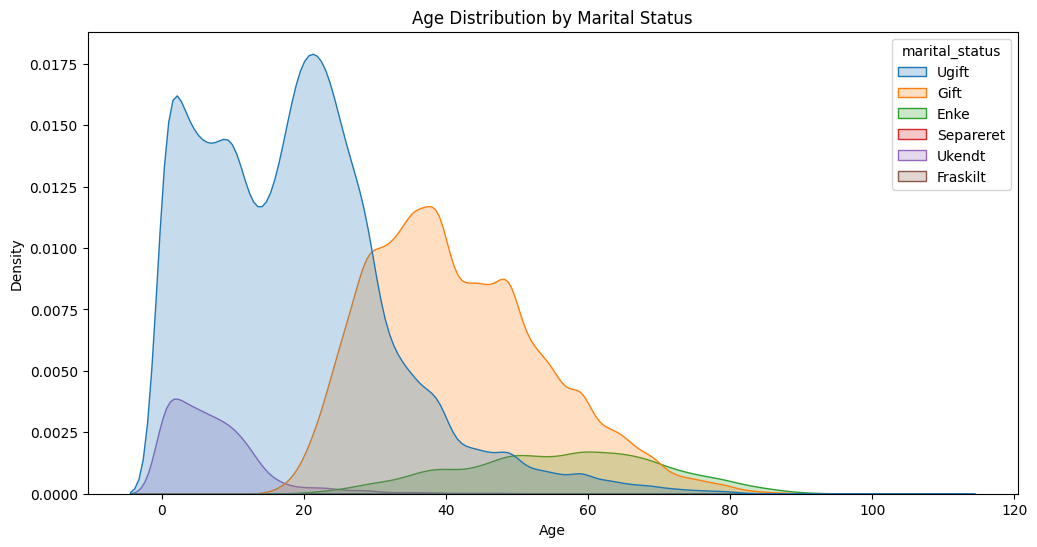

In [3]:
# Try to make a plot over the age distribution and marital status
cleaned_census_df, _, _ = clean_data_age_gender(first_census_df)

plt.figure(figsize=(12, 6))

# KDE plot for age distribution by gender
sns.kdeplot(data=cleaned_census_df, x='age_full_years', hue='køn', fill=True)

plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

# KDE plot for age distribution by marital status
plt.figure(figsize=(12, 6))
sns.kdeplot(data=cleaned_census_df, x='age_full_years', hue='marital_status', shade=True)
plt.title('Age Distribution by Marital Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

C:\Users\mlind\AppData\Local\Temp\ipykernel_18204\3797457112.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_analysis = cleaned_census_df.groupby(['køn', 'age_cohort'])['marital_status'].value_counts(normalize=True).unstack()


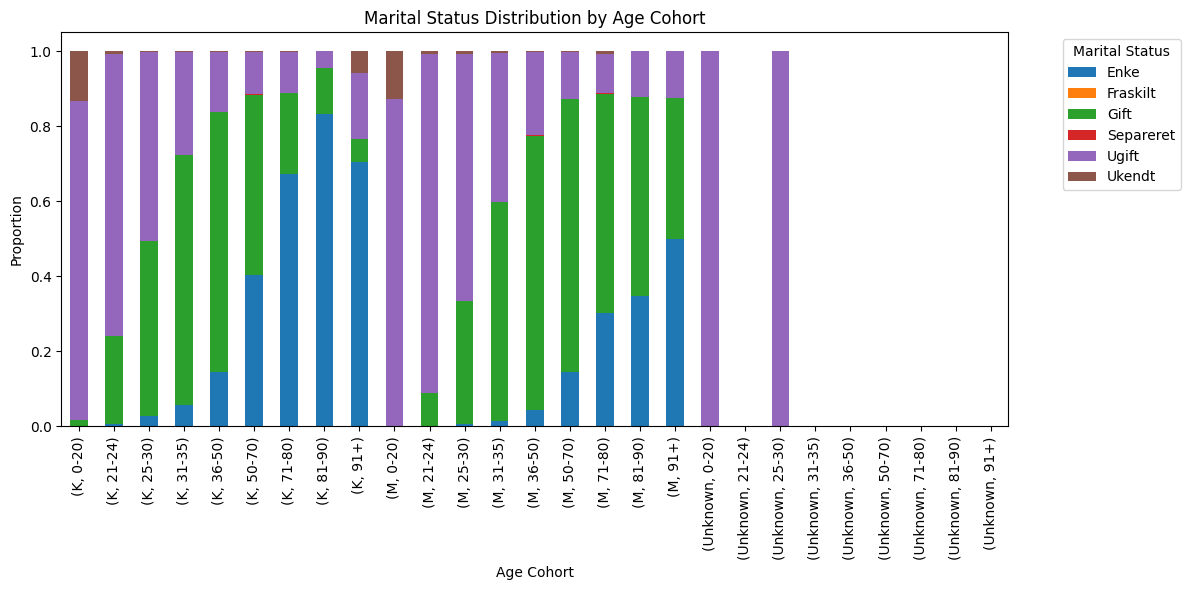

In [4]:
# Create age cohorts
cleaned_census_df['age_cohort'] = pd.cut(cleaned_census_df['age_full_years'], 
                          bins=[0, 20, 24, 30, 35, 50, 70, 80, 90, 100],
                          labels=['0-20', '21-24', '25-30', '31-35', '36-50', '50-70', '71-80', '81-90', '91+'])

# Analyze marital status by age cohort
cohort_analysis = cleaned_census_df.groupby(['køn', 'age_cohort'])['marital_status'].value_counts(normalize=True).unstack()

# Visualize the results
cohort_analysis.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Marital Status Distribution by Age Cohort')
plt.xlabel('Age Cohort')
plt.ylabel('Proportion')
plt.legend(title='Marital Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Part 2: Try to make a marital status plot based on employment

In [5]:
third_census_df = pd.read_csv(census_data_dir / "cph" / 'Rigsarkivet_folketælling_Kobenhavn_amt_1834.csv', delimiter='$')
cleaned_census_df_employment, _, _ = clean_data_age_gender(third_census_df)

In [6]:
# Define the function we use to find the job category
def find_job_category(job: str, dict_of_categories: dict[str, List[str]], dict_of_non_occopations: dict[str, List[str]]):
    for category, job_list in dict_of_categories.items():
        for jobs_name in job_list:
            if str(job) in jobs_name:
                return category
    for category, job_list in dict_of_non_occopations.items():
        for jobs_name in job_list:
            if str(job) in jobs_name:
                return category
    return 'Uncertain Employment'

In [7]:
# We use the categorization of occopations from Claude
job_categories: dict = json.load(open(Path.cwd().parent / 'data' / 'filters' / 'merged-danish-jobs-1800s.json'))
non_occopations: List[str] = json.load(open(Path.cwd().parent / 'data' / 'filters' / 'merged-uncertain-danish-jobs-1800s.json'))
cleaned_census_df_employment['employment category'] = cleaned_census_df_employment['Erhverv'].apply(lambda x: find_job_category(x, job_categories, non_occopations))

# remove rows with NA in the employment category
cleaned_census_df_employment = cleaned_census_df_employment.dropna(subset=['employment category'])

<Axes: xlabel='employment category'>

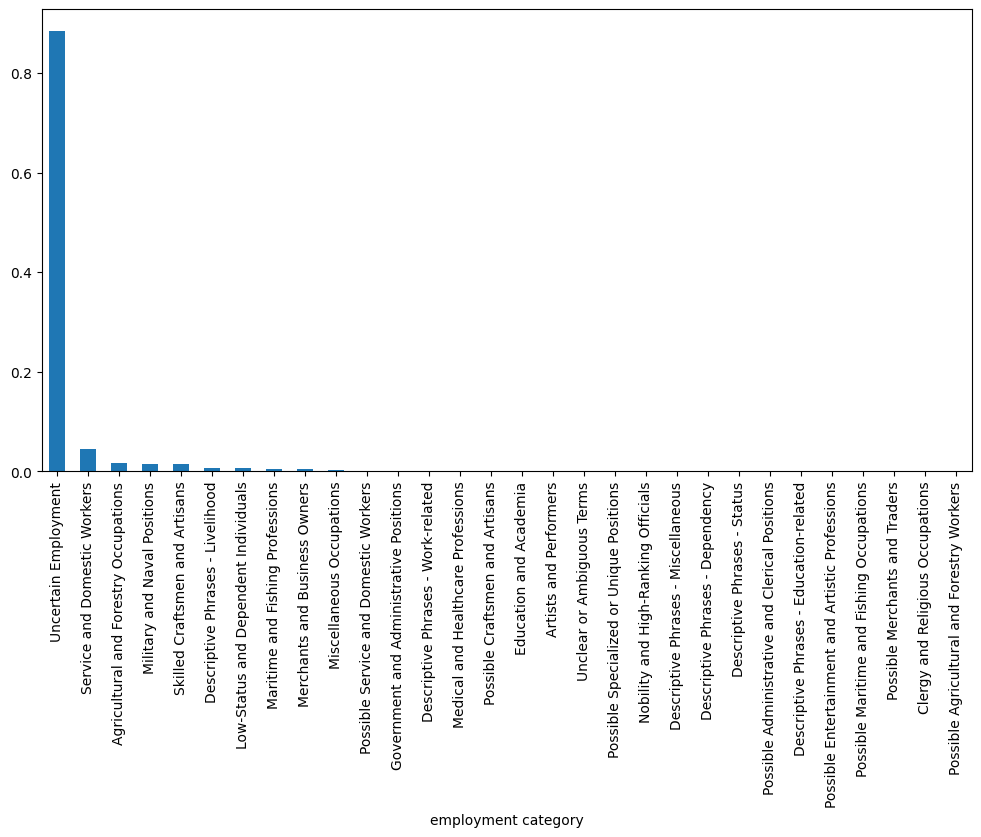

In [8]:
cleaned_census_df_employment['employment category'].value_counts(normalize=True).plot(kind='bar', figsize=(12, 6))

<Axes: xlabel='employment category'>

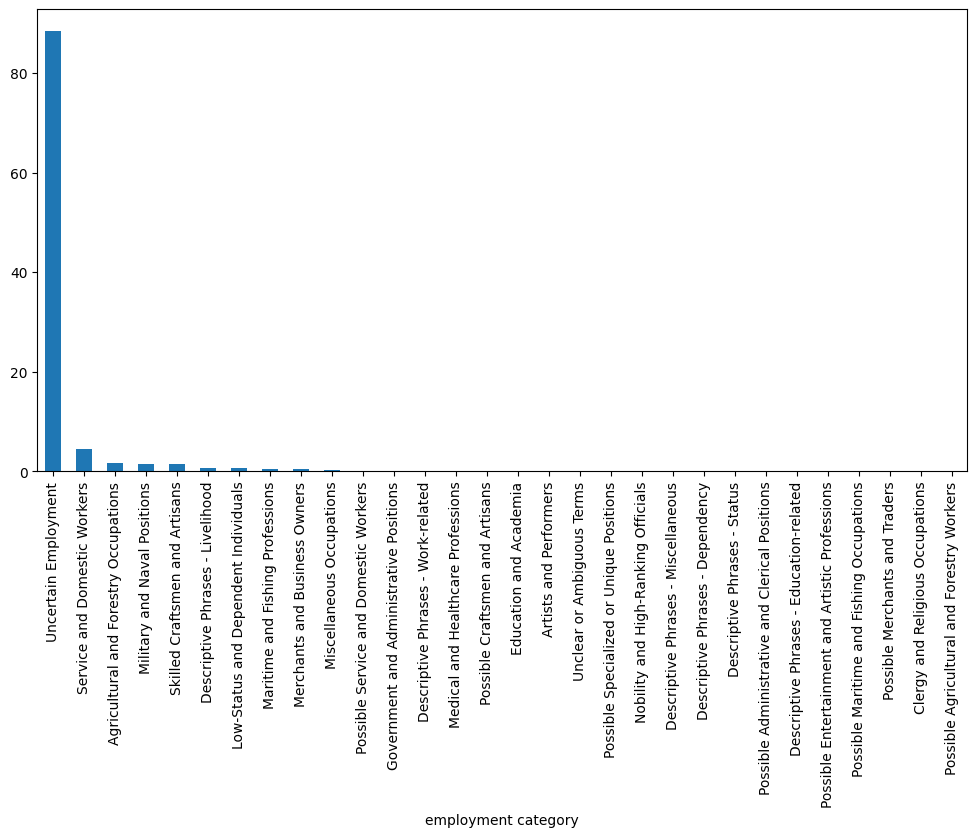

In [18]:
# we try to calculate the avarage age of the different job categories
relative_frequency = cleaned_census_df_employment['employment category'].value_counts(normalize=True) * 100
relative_frequency.plot(kind='bar', figsize=(12, 6))

<Axes: xlabel='employment category'>

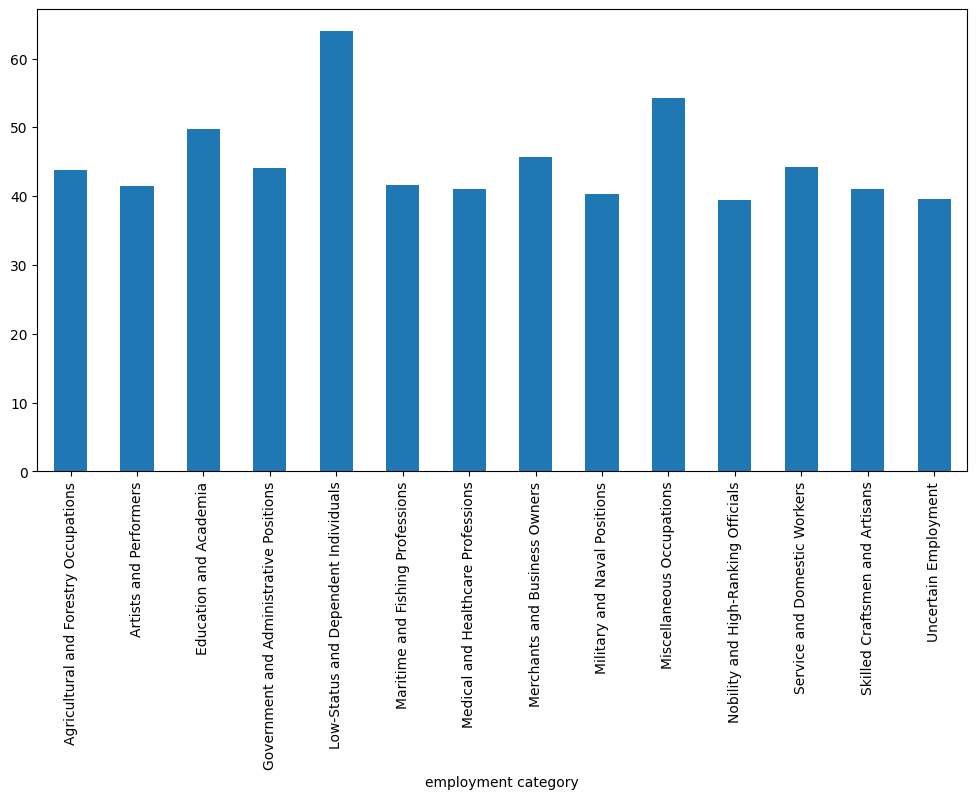

In [22]:
# We try to calculate the average age of married persons of different job categories
married_persons = cleaned_census_df_employment[cleaned_census_df_employment['marital_status'] == 'Gift']
average_age_married = married_persons.groupby('employment category')['age_full_years'].mean()
average_age_married.plot(kind='bar', figsize=(12, 6))